In [17]:
import numpy 
import pandas
import cobra
import scipy, scipy.signal
from pathlib import Path
from cobra.io import load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model, load_model, to_json
import logging
import time 
import os
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.family':'sans-serif',
                            'font.size':20, 
                            'xtick.labelsize':30, 
                            'ytick.labelsize':30, 
                            'figure.figsize':(20, 10), 
                            'axes.labelsize':40})

import seaborn
import pingouin 
import scipy, scipy.stats
from scipy.stats import ttest_ind
import statsmodels, statsmodels.stats, statsmodels.stats.multitest
import cobamp
import docplex
import gseapy
import peat
import bioservices
import keggtools
from bioservices import KEGG
from keggtools import Resolver
import gseapy
import escher
import scipy.io
import json
from escher import Builder, rc
from cobra import Model, Reaction, Metabolite

data_dir = Path(".") / ".." / "src" / "cobra" / "data"
data_dir = data_dir.resolve()

## 1. Generate fluxes for 100 points on an Ecoli.core Model with decreasing oxygen

In [18]:
model = load_model('e_coli_core')

In [19]:
model

Name,e_coli_core
Memory address,0x07f8a58c7db20
Number of metabolites,72
Number of reactions,95
Number of groups,0
Objective expression,1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5
Compartments,"extracellular space, cytosol"


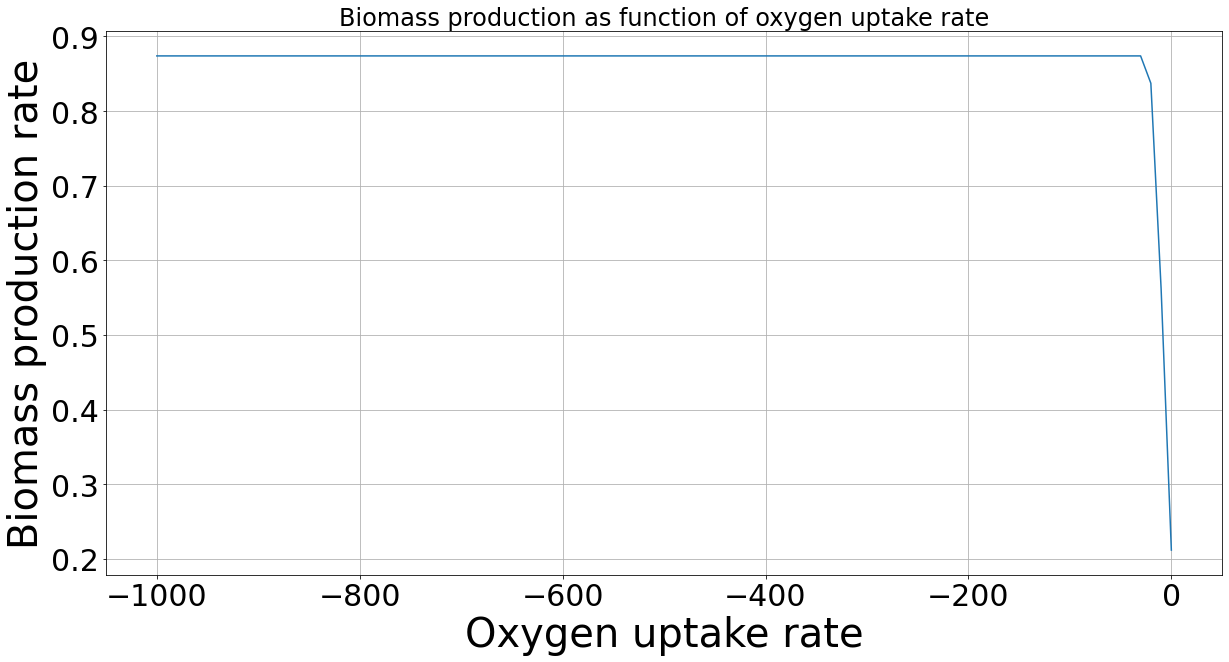

In [20]:
oxygen_fluxes = numpy.linspace(model.reactions.EX_o2_e.lower_bound, 0, 100)

resulting_fluxes = []

for flux in oxygen_fluxes:
    model.reactions.EX_o2_e.lower_bound = flux
    solution = model.optimize()
    if solution.status == 'optimal':
        resulting_fluxes.append(solution.fluxes.BIOMASS_Ecoli_core_w_GAM)
    else:
        resulting_fluxes.append(numpy.nan)
        

matplotlib.pyplot.figure(figsize=(20, 10))
matplotlib.pyplot.plot(oxygen_fluxes, resulting_fluxes)
matplotlib.pyplot.xlabel('Oxygen uptake rate')
matplotlib.pyplot.ylabel('Biomass production rate')
matplotlib.pyplot.title('Biomass production as function of oxygen uptake rate')
matplotlib.pyplot.grid(True)
matplotlib.pyplot.show()       